In [47]:
import pandas as pd
import numpy as np
import json
import os
import operator
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import evaluate_queries as evaluate_queries

import utils

from pathlib import Path

from sklearn.metrics import ndcg_score
from tqdm import tqdm

sns.set(rc={'figure.figsize':(24, 14)}, font_scale=2)
sns.set_style(style='whitegrid')

# Functions

In [8]:
def update_df(df, scores_path):
    '''
    Given a wikipages queries dataframe `df` and its respective `scores_path`
    update df to map the various scores @k for each wikipage
    '''
    for file in os.listdir(scores_path):
        with open(scores_path + file, 'r') as f:
            scores_dict = json.load(f)

        wikipage_id_to_ndcg = {}
        wikipage_id_to_auc = {}
        wikipage_id_to_precision = {}
        wikipage_id_to_recall = {}

        # Loop over all wikipages in the `scores_dict`
        for wikipage_id in scores_dict:
            ndcg = scores_dict[wikipage_id]['ndcg']
            auc = scores_dict[wikipage_id]['auc']
            precision = scores_dict[wikipage_id]['precision_at_k']
            recall = scores_dict[wikipage_id]['recall_at_k']

            wikipage_id_to_ndcg[int(wikipage_id)] = ndcg
            wikipage_id_to_auc[int(wikipage_id)] = auc
            wikipage_id_to_precision[int(wikipage_id)] = precision
            wikipage_id_to_recall[int(wikipage_id)] = recall
        
        k = file.split('_')[-1].split('.')[0]
        df['ndcg@'+k] = np.nan
        df['auc@'+k] = np.nan
        df['precision@'+k] = np.nan
        df['recall@'+k] = np.nan

        df['ndcg@'+k] = df['wikipage_id'].map(wikipage_id_to_ndcg)
        df['auc@'+k] = df['wikipage_id'].map(wikipage_id_to_auc)
        df['precision@'+k] = df['wikipage_id'].map(wikipage_id_to_precision)
        df['recall@'+k] = df['wikipage_id'].map(wikipage_id_to_recall)

    return df

def get_query_df_dict(query_df_base_dir, score_paths_base_dir, min_tuple_width, mode, tuples_per_query_list):
    # Dictionary keyed by the number of tuples per query to the query dataframe that contains the NDCG scores at various k values
    query_df_dict = {}

    for tuples_per_query in tuples_per_query_list:
        df = pd.read_pickle(query_df_base_dir+'minTupleWidth_2_tuplesPerQuery_'+str(tuples_per_query)+'.pickle')  
        scores_path = score_paths_base_dir + 'minTupleWidth_' + str(min_tuple_width) + '_tuplesPerQuery_' + str(tuples_per_query) + '/' + mode + '/'

        query_df_dict[tuples_per_query] = update_df(df, scores_path)
    
    return query_df_dict

def get_ndcg_scores_at_k_stats(df_dict, top_k_vals, tuples_per_query_list):
    '''
    Returns the dictionaries indexed by the tuples_per_query corresponding to the mean and standard deviation of the ndcg@k scores
    '''
    mean_ndcg_scores_at_k = {}
    std_ndcg_scores_at_k = {}
    for tuples_per_query in tuples_per_query_list:
        mean_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].mean() for k in top_k_vals]
        std_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].std() for k in top_k_vals]
    return mean_ndcg_scores_at_k, std_ndcg_scores_at_k

In [9]:
def get_relevant_wikipages(wikipage_id, relevance_scores_dir):
    with open(relevance_scores_dir + str(wikipage_id) + '.json') as fp:
        relevant_wikipages = json.load(fp)
    print(relevant_wikipages)

def get_wikipage_attributes(wikipage_id, wikipage_to_attributes_dict, df):
    # Convert the wikipage_id into a wikipage name
    wikipage = df[df['wikipage_id'] == wikipage_id]['wikipage'].values[0]
    wikipage = wikipage.split('/')[-1]
    print(wikipage_to_attributes_dict[wikipage])

def get_query(wikipage_id, queries_path, k=None):
    with open(queries_path + 'wikipage_' + str(wikipage_id) + '.json') as fp:
        query_dict = json.load(fp)
    for tuple in query_dict['queries']:
        print(tuple)

def get_top_k_results(wikipage_id, scores_dir, k=10):
    with open(scores_dir + 'wikipage_' + str(wikipage_id)+'/search_output/filenameToScore.json') as fp:
        scores_dicts = json.load(fp)['scores']
    top_k_wikipages = []
    for dict in scores_dicts[:k]:
        top_k_wikipages.append(dict['pgTitle'])
    return top_k_wikipages

def get_top_k_bm25(wikipage_id, bm_25_scores_dir, table_to_wikipage_id_dict, df, k=10):
    scores_df = pd.read_csv(bm_25_scores_dir, sep="\t", index_col=False, names=["wikipage_id", "query", "table_id", "rank", "score", "field"])
    scores_df = scores_df[scores_df['wikipage_id'] == wikipage_id].sort_values(by='rank')
    top_k_wikipages = []
    for idx, row in scores_df.head(k).iterrows():
        wikipage_id = table_to_wikipage_id_dict[row['table_id']]
        wikipage = df[df['wikipage_id']==wikipage_id]['wikipage'].values[0].split('/')[-1]
        top_k_wikipages.append(wikipage)
    return top_k_wikipages   

def get_query_summary(wikipage_id, df, relevance_scores_dir, queries_path, wikipage_to_attributes_dict, scores_dir, bm_25_scores_dir, table_to_wikipage_id_dict, k=10):
    print("Query Constructed from Wikipedia Page:", df[df['wikipage_id'] == wikipage_id]['wikipage'].values[0])

    print("\nQuery Tuples:")
    get_query(wikipage_id, queries_path)

    print('\nWikipedia Categories of query Wikipage:')
    get_wikipage_attributes(wikipage_id, wikipage_to_attributes_dict, df)

    print('\nRelevant Wikipages (Ground Truth):')
    get_relevant_wikipages(wikipage_id, relevance_scores_dir)

    print("\nTop-" + str(k), "tables found using Adj. Jaccard (Unweighted + Avg. Similarity per Column):")
    print(get_top_k_results(wikipage_id=wikipage_id, scores_dir=scores_dir, k=k))

    print("\nTop-" + str(k), "tables found using Adj. Jaccard (Weighted + Avg. Similarity per Column):")
    print(get_top_k_results(wikipage_id=wikipage_id, scores_dir=scores_dir+'weighted/avg_similarity_per_col/', k=k))

    print("\nTop-" + str(k), "tables found using Adj. Jaccard (Weighted + Max Similarity per Column):")
    print(get_top_k_results(wikipage_id=wikipage_id, scores_dir=scores_dir+'weighted/max_similarity_per_col/', k=k))

    print("\nTop-" + str(k), "tables found using BM25 (Entity Queries):")
    print(get_top_k_bm25(wikipage_id=wikipage_id, bm_25_scores_dir=bm_25_scores_dir+'entities/content.txt', 
        table_to_wikipage_id_dict=table_to_wikipage_id_dict, df=df, k=k))

    print("\nTop-" + str(k), "tables found using BM25 (Text Queries):")
    print(get_top_k_bm25(wikipage_id=wikipage_id, bm_25_scores_dir=bm_25_scores_dir+'text/content.txt', 
        table_to_wikipage_id_dict=table_to_wikipage_id_dict, df=df, k=k))

# Jaccard of Types

In [10]:
query_df_base_dir = '../../data/queries/wikipages/query_dataframes/expanded_wikipages/sampled_queries/'
min_tuple_width=2
tuples_per_query_list = [1,2,5,10]
top_k_vals = [5,10,15,20,50,100,150,200]

In [11]:
adj_jaccard_weighted_max_sim_per_col_scores='eval_over_search_output/wikipages_expanded/sampled_queries/adjusted_jaccard/weighted/max_similarity_per_col/search_output/'


# Get the dataframes of the evaluation scores at different # of tuples per query 
adj_jaccard_weighted_max_sim_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=adj_jaccard_weighted_max_sim_per_col_scores,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

# Get dictionaries keyed by the tuples per query mapping to a list of the NDCG scores at the specified top-k
adj_jaccard_mean_ndcg_scores_at_k_weighted_max_sim, _ = get_ndcg_scores_at_k_stats(adj_jaccard_weighted_max_sim_df, top_k_vals, tuples_per_query_list)

In [12]:
adj_jaccard_weighted_max_sim_df[1]

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,categories_relevant_wikipages,...,precision@100,recall@100,ndcg@5,auc@5,precision@5,recall@5,ndcg@150,auc@150,precision@150,recall@150
205,https://en.wikipedia.org/wiki/Australian_feder...,205,1,[table-0002-277.json],[62],3.0,1.0,table-0002-277.json,[2],42.0,...,0.08,0.121212,0.876251,0.559697,0.6,0.045455,0.387625,0.559697,0.053333,0.121212
335,https://en.wikipedia.org/wiki/Colorado_statist...,335,1,[table-0002-837.json],[69],3.0,1.0,table-0002-837.json,[0],55.0,...,0.05,0.087719,0.481809,0.542908,0.4,0.035088,0.363463,0.542908,0.033333,0.087719
3452,https://en.wikipedia.org/wiki/World_Fencing_Ch...,3452,4,"[table-0022-580.json, table-0022-581.json, tab...","[221, 61, 41, 33]",6.0,1.0,table-0022-580.json,[13],44.0,...,0.01,0.014286,0.378935,0.506109,0.2,0.014286,0.227045,0.506109,0.006667,0.014286
5050,https://en.wikipedia.org/wiki/2004_Bradford_Bu...,5050,3,"[table-0033-213.json, table-0033-217.json, tab...","[23, 29, 30]",5.0,1.0,table-0033-219.json,[0],19.0,...,0.15,0.245902,0.686302,0.622179,1.0,0.081967,0.397527,0.622179,0.100000,0.245902
6218,https://en.wikipedia.org/wiki/List_of_Super_Bo...,6218,2,"[table-0041-812.json, table-0041-814.json]","[144, 51]",6.0,1.0,table-0041-812.json,[0],16.0,...,0.06,0.171429,0.464373,0.642041,0.2,0.028571,0.375327,0.642041,0.066667,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239771,https://en.wikipedia.org/wiki/2007_Houston_Ast...,239771,6,"[table-1625-64.json, table-1625-65.json, table...","[40, 30, 41, 41, 48, 38]",4.0,1.0,table-1625-68.json,[4],77.0,...,0.48,0.152866,0.383860,0.653699,0.8,0.012739,0.382973,0.653699,0.360000,0.171975
242059,https://en.wikipedia.org/wiki/List_of_Fiesta_B...,242059,2,"[table-1640-699.json, table-1640-701.json]","[53, 18]",4.0,1.0,table-1640-699.json,[0],79.0,...,0.27,0.129187,0.415020,0.575702,0.8,0.019139,0.367423,0.575702,0.200000,0.143541
242282,https://en.wikipedia.org/wiki/Super_Prestige_P...,242282,1,[table-1641-979.json],[49],5.0,1.0,table-1641-979.json,[1],23.0,...,0.02,0.043478,0.858315,0.531613,0.4,0.043478,0.485458,0.531613,0.013333,0.043478
242991,https://en.wikipedia.org/wiki/List_of_places_o...,242991,2,"[table-1646-858.json, table-1646-859.json]","[136, 68]",4.0,1.0,table-1646-858.json,[0],63.0,...,0.18,0.134328,0.522408,0.667119,0.6,0.022388,0.421648,0.667119,0.166667,0.186567


# Embeddings

In [13]:
query_df_base_dir = '../../data/queries/wikipages/query_dataframes/expanded_wikipages/sampled_queries/'
min_tuple_width=2
tuples_per_query_list = [1,2,5,10]
top_k_vals = [5,10,15,20,50,100,150,200]

In [14]:
emb_norm_cos_max_sim_per_col_scores='eval_over_search_output/wikipages_expanded/sampled_queries/embeddings/norm_cos/max_similarity_per_col/search_output/'


# Get the dataframes of the evaluation scores at different # of tuples per query 
emb_norm_cos_max_sim_per_col_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=emb_norm_cos_max_sim_per_col_scores,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

# Get dictionaries keyed by the tuples per query mapping to a list of the NDCG scores at the specified top-k
emb_norm_cos_max_sim_per_col_mean_ndcg_scores_at_k, _ = get_ndcg_scores_at_k_stats(emb_norm_cos_max_sim_per_col_df, top_k_vals, tuples_per_query_list)

# BM25

In [16]:
tuples_per_query_list = [1,2,5,10]
top_k_vals = [5,10,15,20,50,100,150,200]
with open('evaluation_dataframes/wikipages_expanded/sampled_queries/bm25_dfs_dict.pickle', 'rb') as handle:
    bm25_dfs_dict = pickle.load(handle)

# Comparison across different methods

In [19]:
tuples_per_query_list = [1, 2, 5, 10]
eval_scores=['ndcg', 'auc', 'precision', 'recall']

eval_score_to_eval_df_dict = {}

for eval_score in tqdm(eval_scores):

    eval_df = pd.DataFrame(columns=['mode', 'top-k', eval_score, 'wikipage_id', 'tuples_per_query'])

    # Add Jaccard Of Types in the dataframe for comparison
    for tuples_per_query in tuples_per_query_list:
        df_tmp = adj_jaccard_weighted_max_sim_df[tuples_per_query]
        for _, row in df_tmp.iterrows():
            for k in top_k_vals:
                score_at_k = row[eval_score+'@'+str(k)]
                row_to_append = ['Jaccard of DBpedia Types', k, score_at_k, row['wikipage_id'], tuples_per_query]
                eval_df.loc[len(eval_df.index)] = row_to_append

    # Add Embeddings in the dataframe for comparison
    for tuples_per_query in tuples_per_query_list:
        df_tmp = emb_norm_cos_max_sim_per_col_df[tuples_per_query]
        for _, row in df_tmp.iterrows():
            for k in top_k_vals:
                score_at_k = row[eval_score+'@'+str(k)]
                row_to_append = ['Embeddings (Norm. Cosine)', k, score_at_k, row['wikipage_id'], tuples_per_query]
                eval_df.loc[len(eval_df.index)] = row_to_append

    # Add BM25 scores in the dataframe for comparison
    for tuples_per_query in tuples_per_query_list:
        bm25_entities = bm25_dfs_dict[tuples_per_query]['entities']['content_categories']
        
        for _, row in bm25_entities.iterrows():
            for k in top_k_vals:
                score_at_k = row[eval_score+'@'+str(k)]
                row_to_append = ['BM25', k, score_at_k, row['wikipage_id'], tuples_per_query]
                eval_df.loc[len(eval_df.index)] = row_to_append

    eval_score_to_eval_df_dict[eval_score] = eval_df

with open('evaluation_dataframes/wikipages_expanded/sampled_queries/eval_score_to_eval_df_dict.pickle', 'wb') as handle:
    pickle.dump(eval_score_to_eval_df_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

eval_score_to_eval_df_dict['ndcg']

100%|██████████| 4/4 [01:36<00:00, 24.10s/it]


,mode,top-k,ndcg,wikipage_id,tuples_per_query
0,Jaccard of DBpedia Types,5,0.876251,205,1
1,Jaccard of DBpedia Types,10,0.831041,205,1
2,Jaccard of DBpedia Types,15,0.748745,205,1
3,Jaccard of DBpedia Types,20,0.669918,205,1
4,Jaccard of DBpedia Types,50,0.439844,205,1
...,...,...,...,...,...
11515,BM25,20,0.271578,243407,10
11516,BM25,50,0.271070,243407,10
11517,BM25,100,0.298575,243407,10
11518,BM25,150,0.321236,243407,10


In [24]:
with open('evaluation_dataframes/wikipages_expanded/sampled_queries/eval_score_to_eval_df_dict.pickle', 'rb') as handle:
    eval_score_to_eval_df_dict = pickle.load(handle)

## NDCG Score

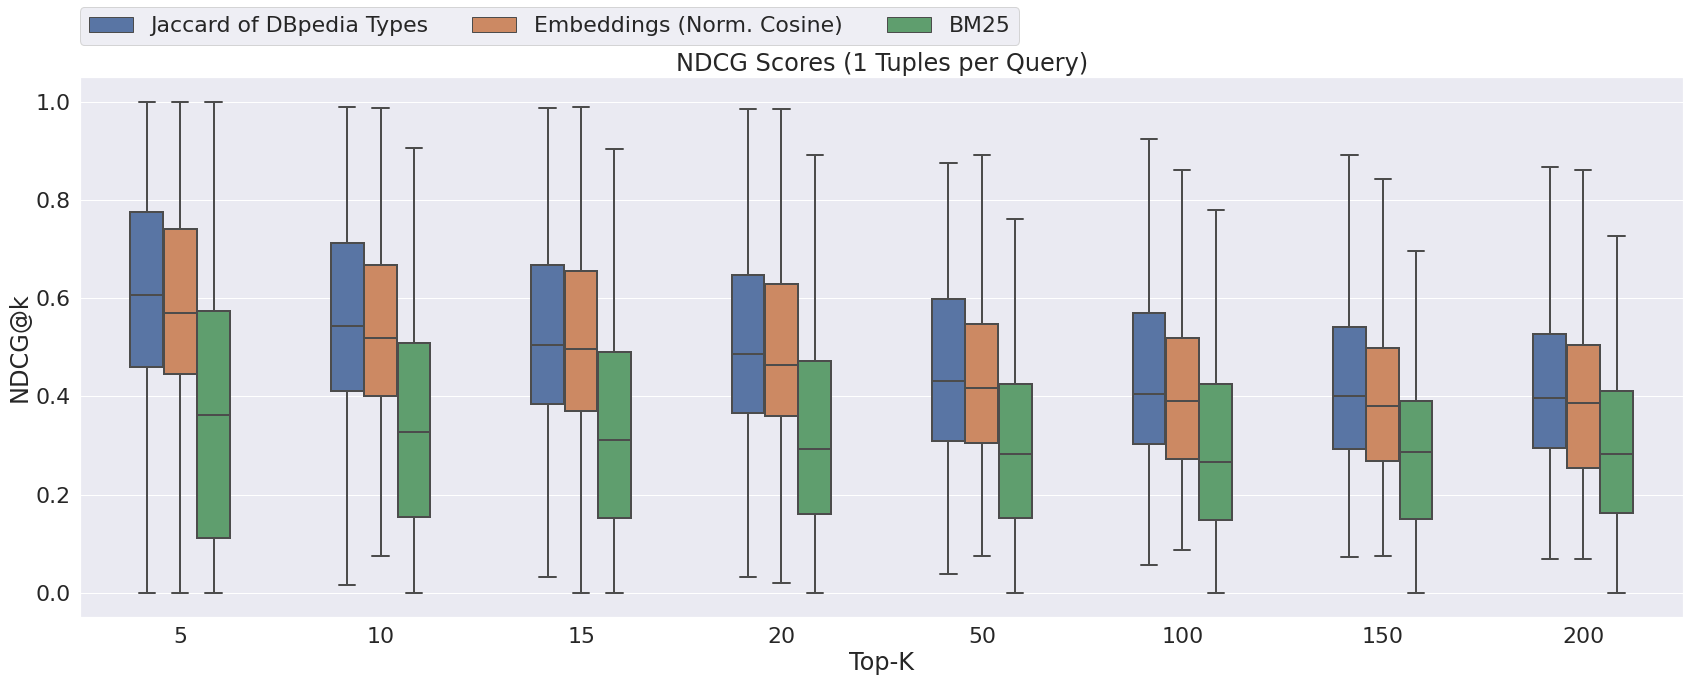

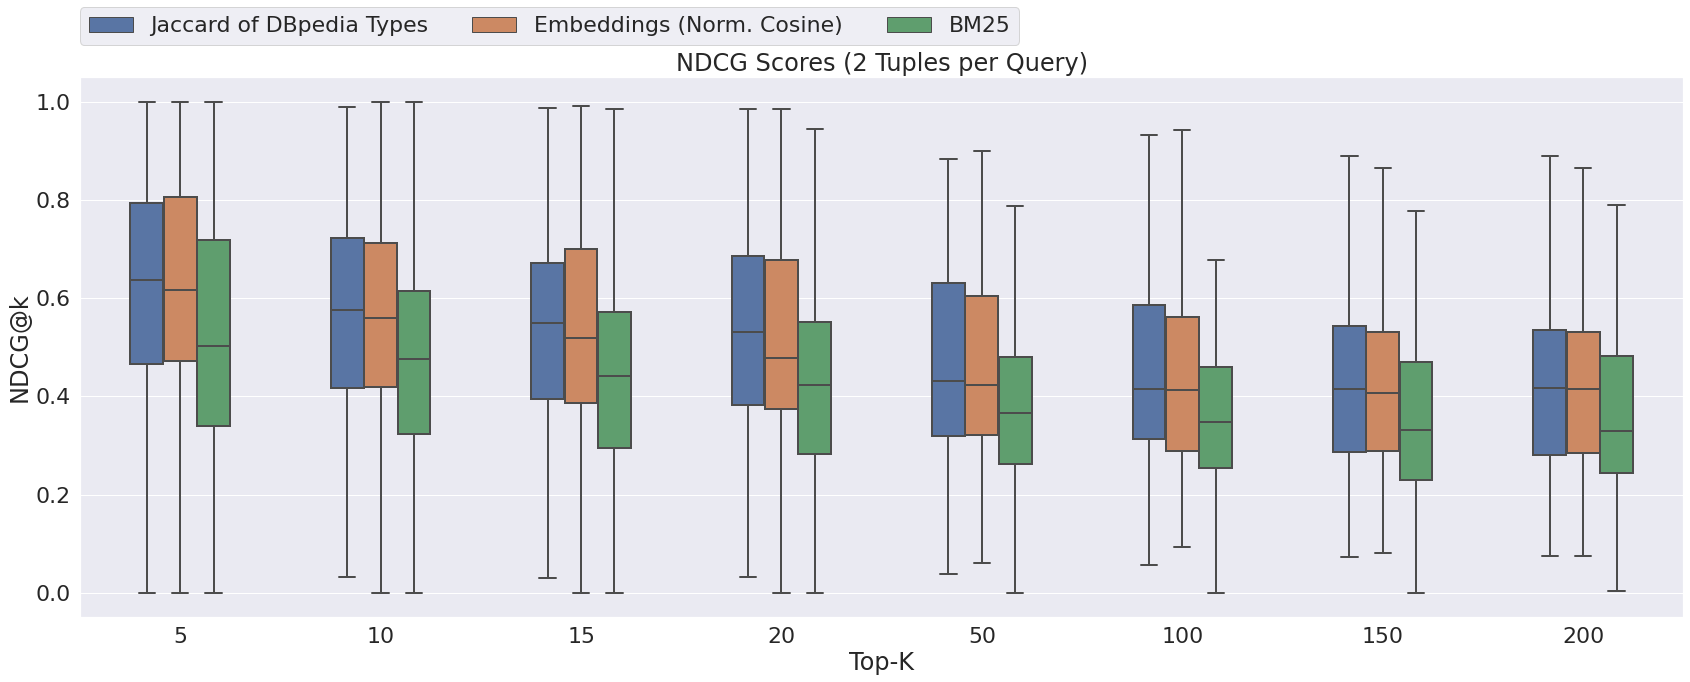

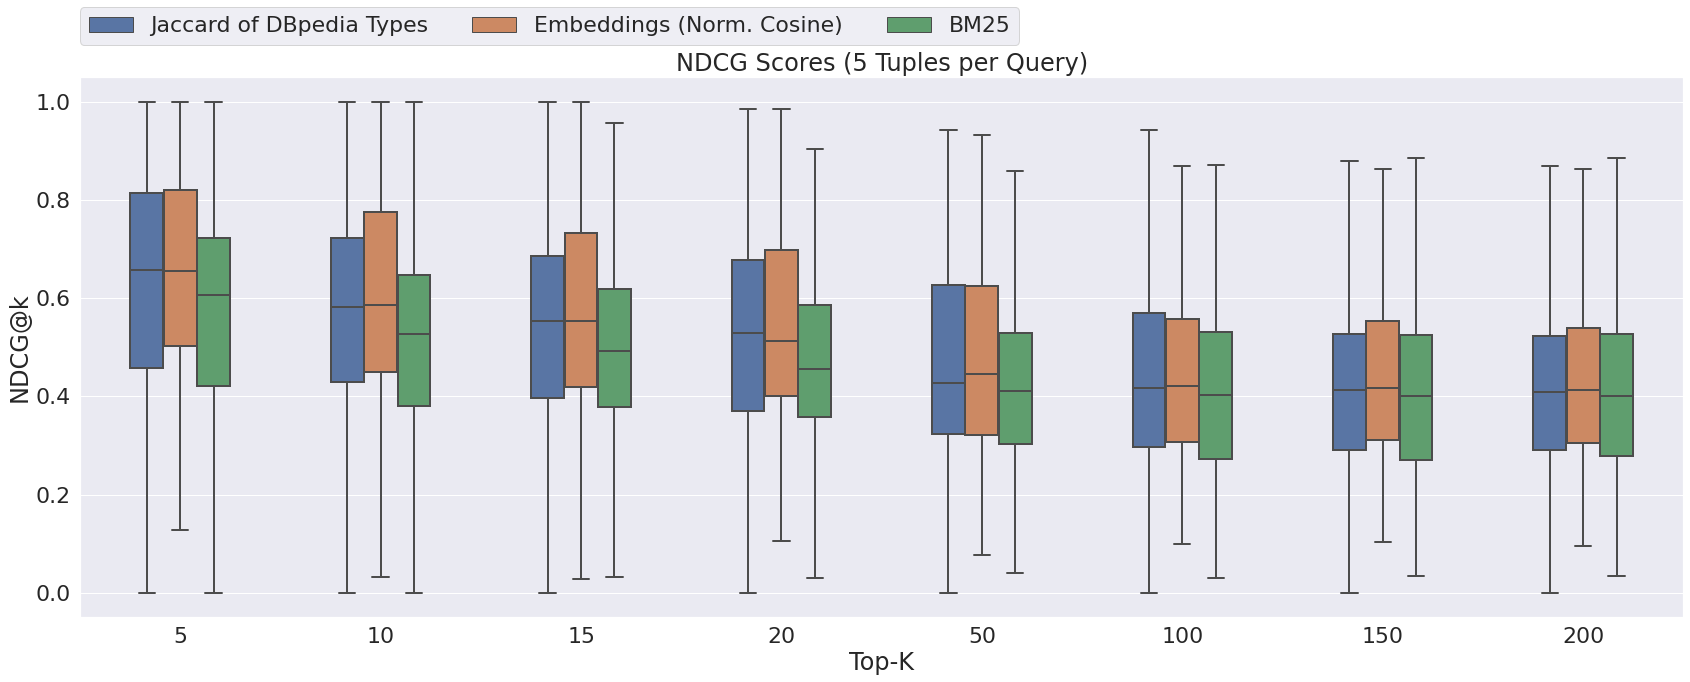

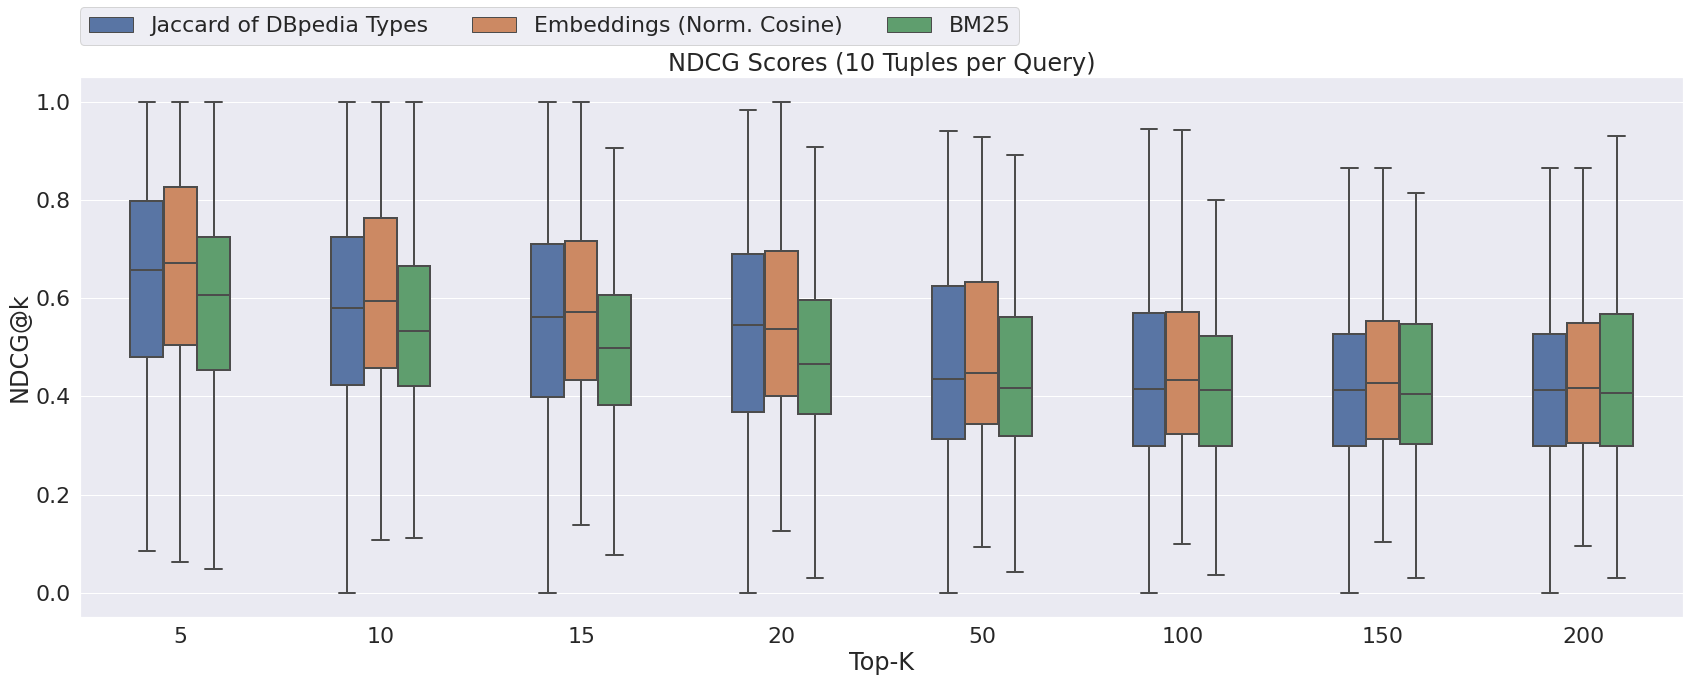

In [50]:
sns.set(rc={'figure.figsize':(24, 10)}, font_scale=2)
for tuples_per_query in tuples_per_query_list:
    plt.figure()
    df = eval_score_to_eval_df_dict['ndcg'][eval_score_to_eval_df_dict['ndcg']['tuples_per_query']==tuples_per_query]
    ax = sns.boxplot(x="top-k", y="ndcg", hue="mode", data=df, showfliers=False, width=0.5, linewidth=2)
    plt.legend(bbox_to_anchor=(0, 1.13), loc=2, borderaxespad=0.,ncol=3)
    plt.xlabel("Top-K");plt.ylabel("NDCG@k");plt.title("NDCG Scores (" + str(tuples_per_query)+ " Tuples per Query)");plt.tight_layout()

## AUC

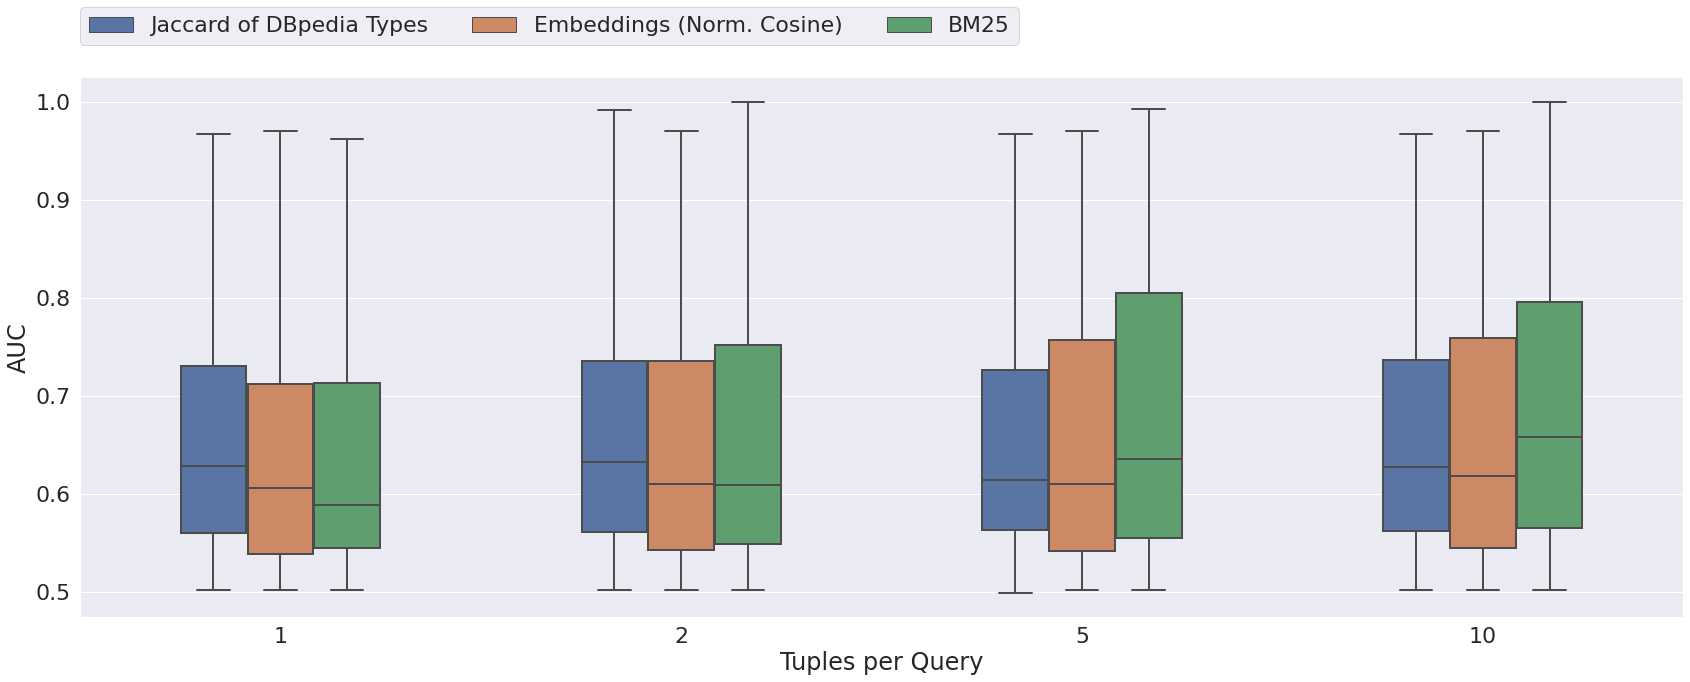

In [46]:
df = eval_score_to_eval_df_dict['auc'][eval_score_to_eval_df_dict['auc']['top-k']==5]
ax = sns.boxplot(x="tuples_per_query", y="auc", hue="mode", data=df, showfliers=False, width=0.5, linewidth=2)
plt.legend(bbox_to_anchor=(0, 1.13), loc=2, borderaxespad=0.,ncol=3)
plt.xlabel("Tuples per Query");plt.ylabel("AUC");plt.tight_layout()

## Precision@k

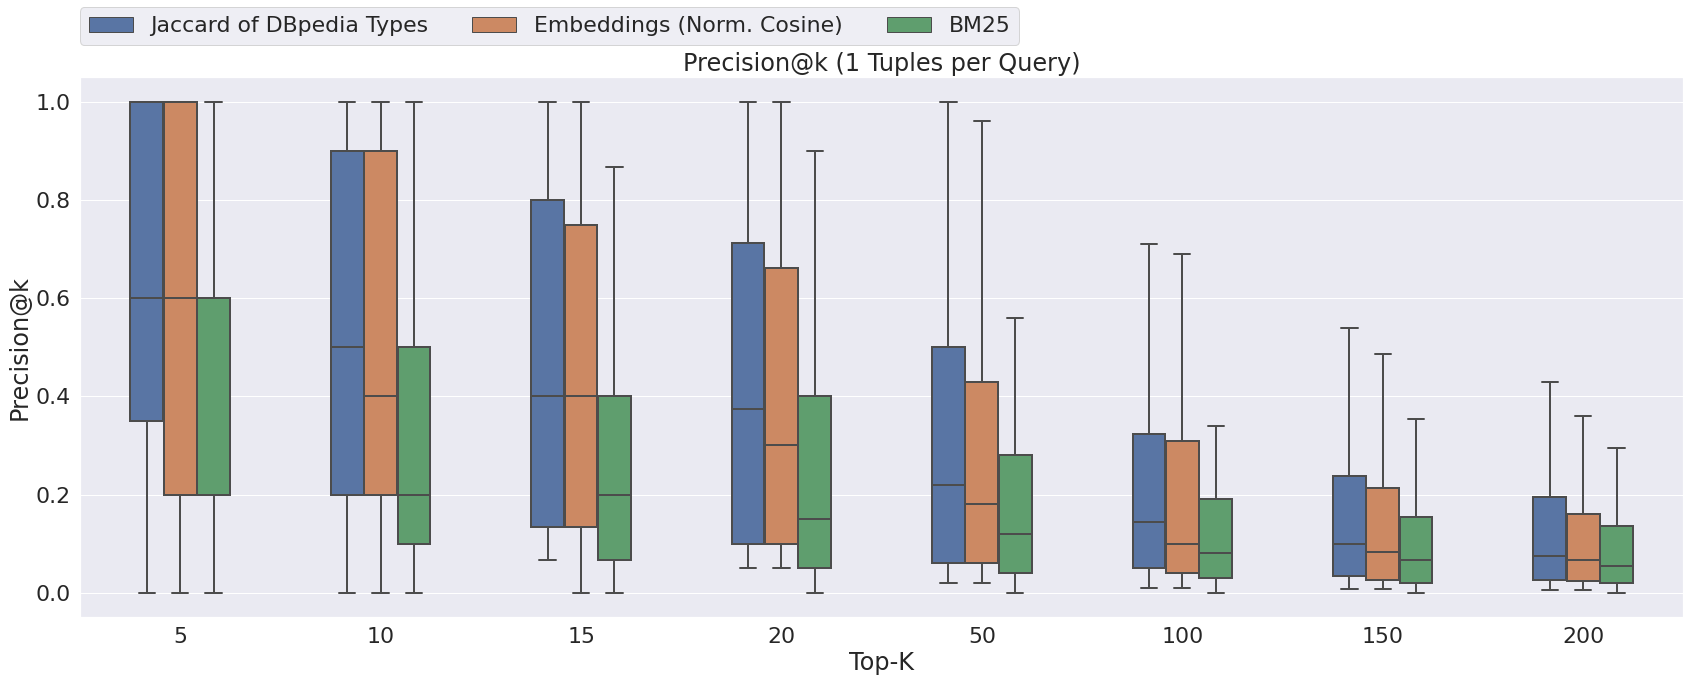

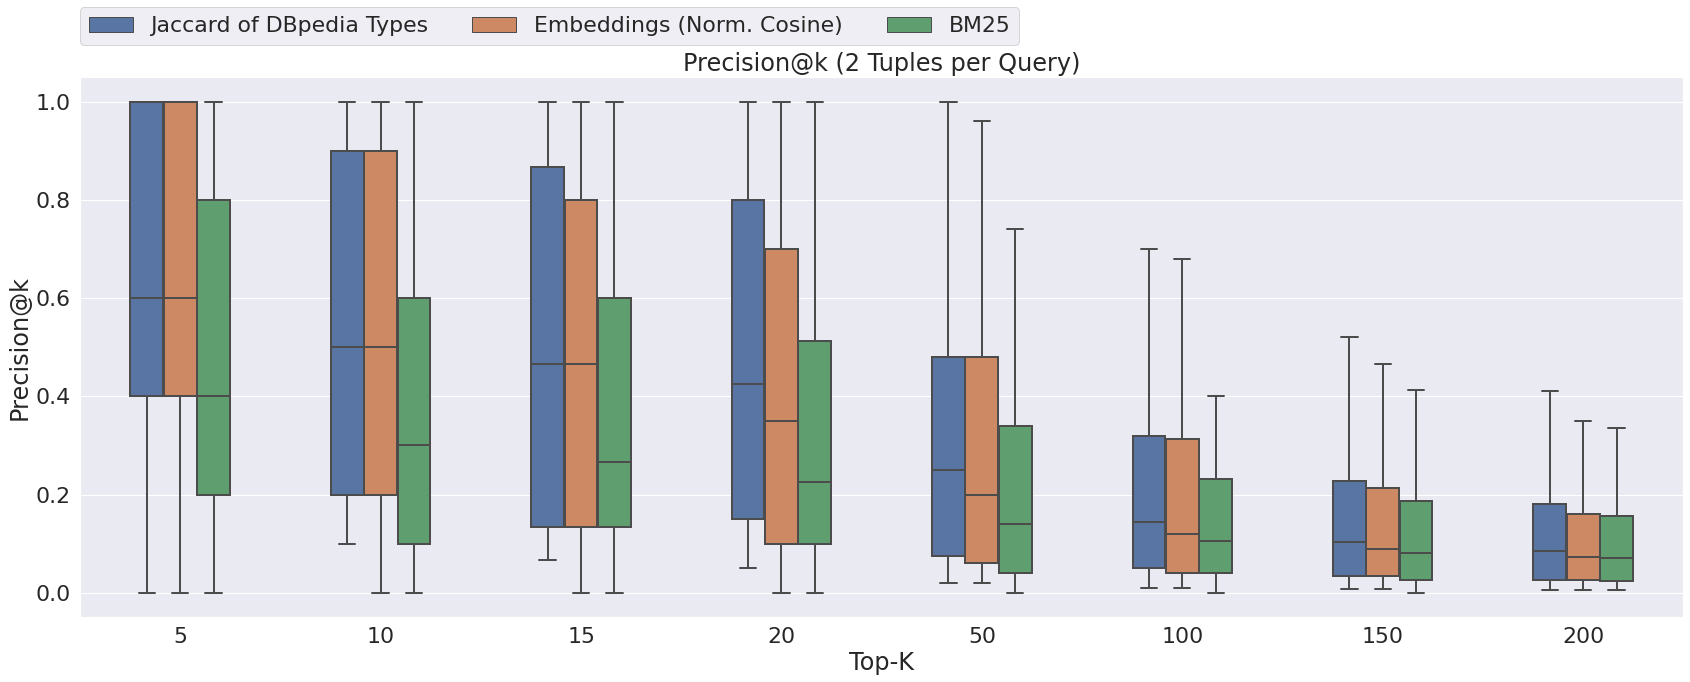

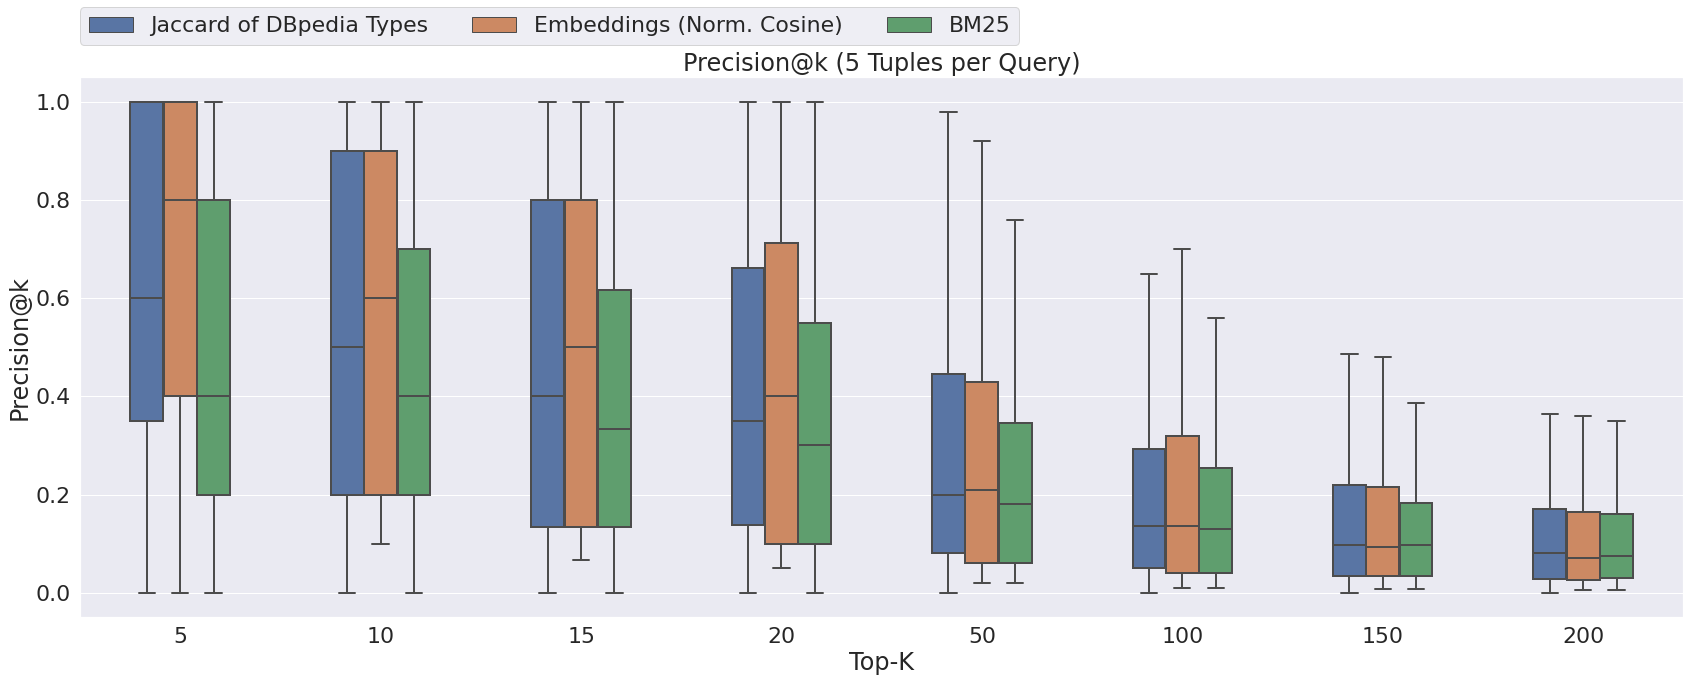

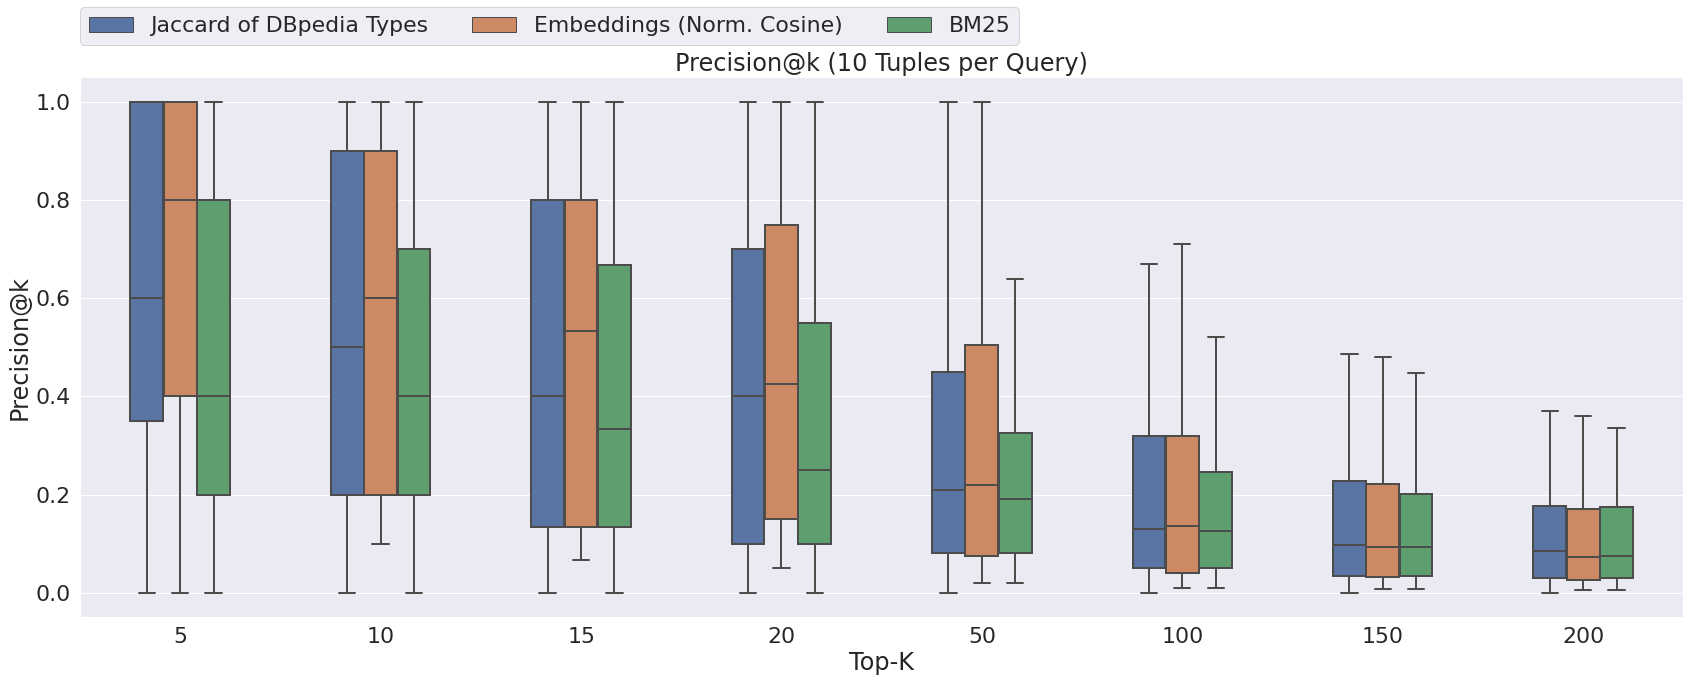

In [51]:
for tuples_per_query in tuples_per_query_list:
    plt.figure()
    df = eval_score_to_eval_df_dict['precision'][eval_score_to_eval_df_dict['precision']['tuples_per_query']==tuples_per_query]
    ax = sns.boxplot(x="top-k", y="precision", hue="mode", data=df, showfliers=False, width=0.5, linewidth=2)
    plt.legend(bbox_to_anchor=(0, 1.13), loc=2, borderaxespad=0.,ncol=3)
    plt.xlabel("Top-K");plt.ylabel("Precision@k");plt.title("Precision@k (" + str(tuples_per_query)+ " Tuples per Query)");plt.tight_layout()

## Recall@k

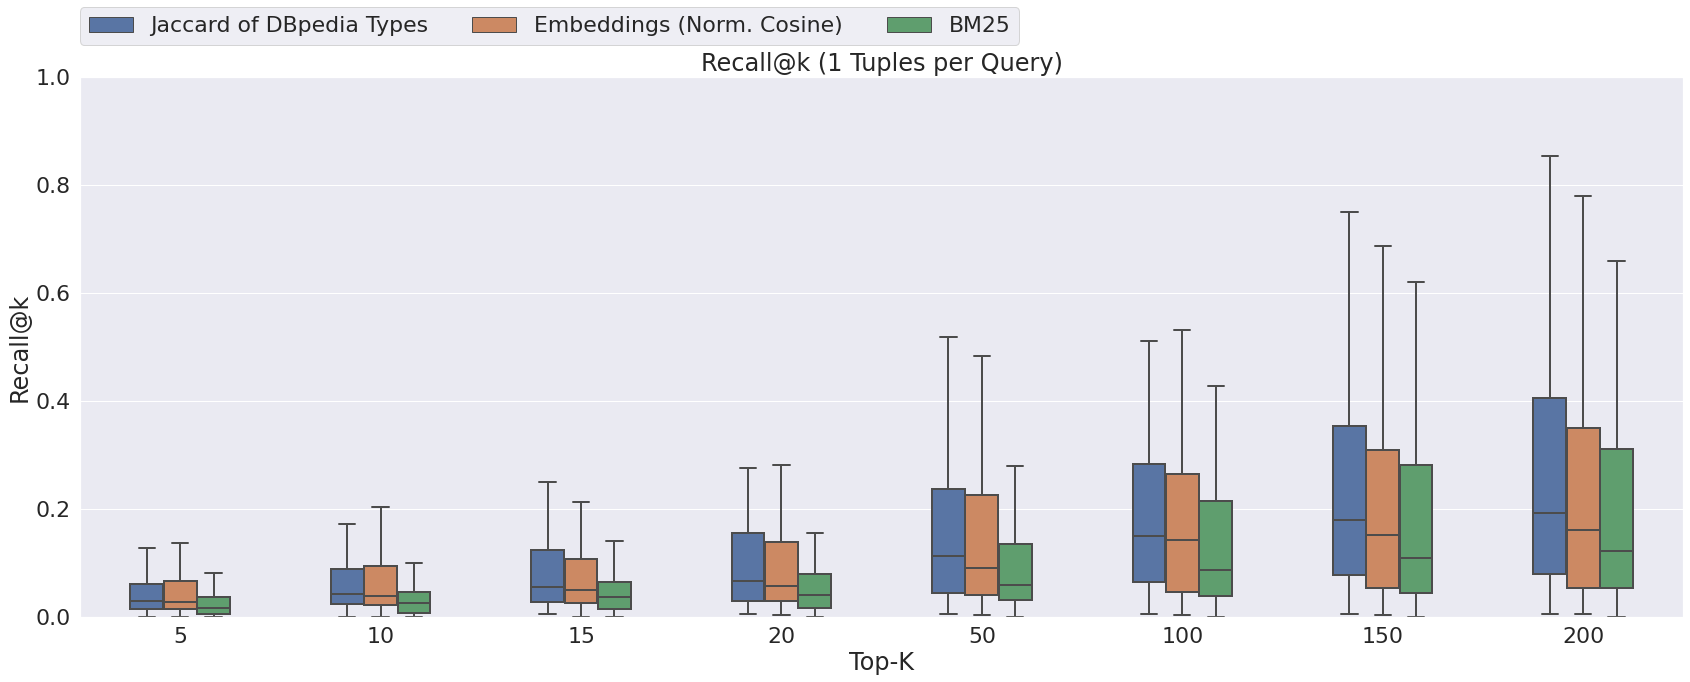

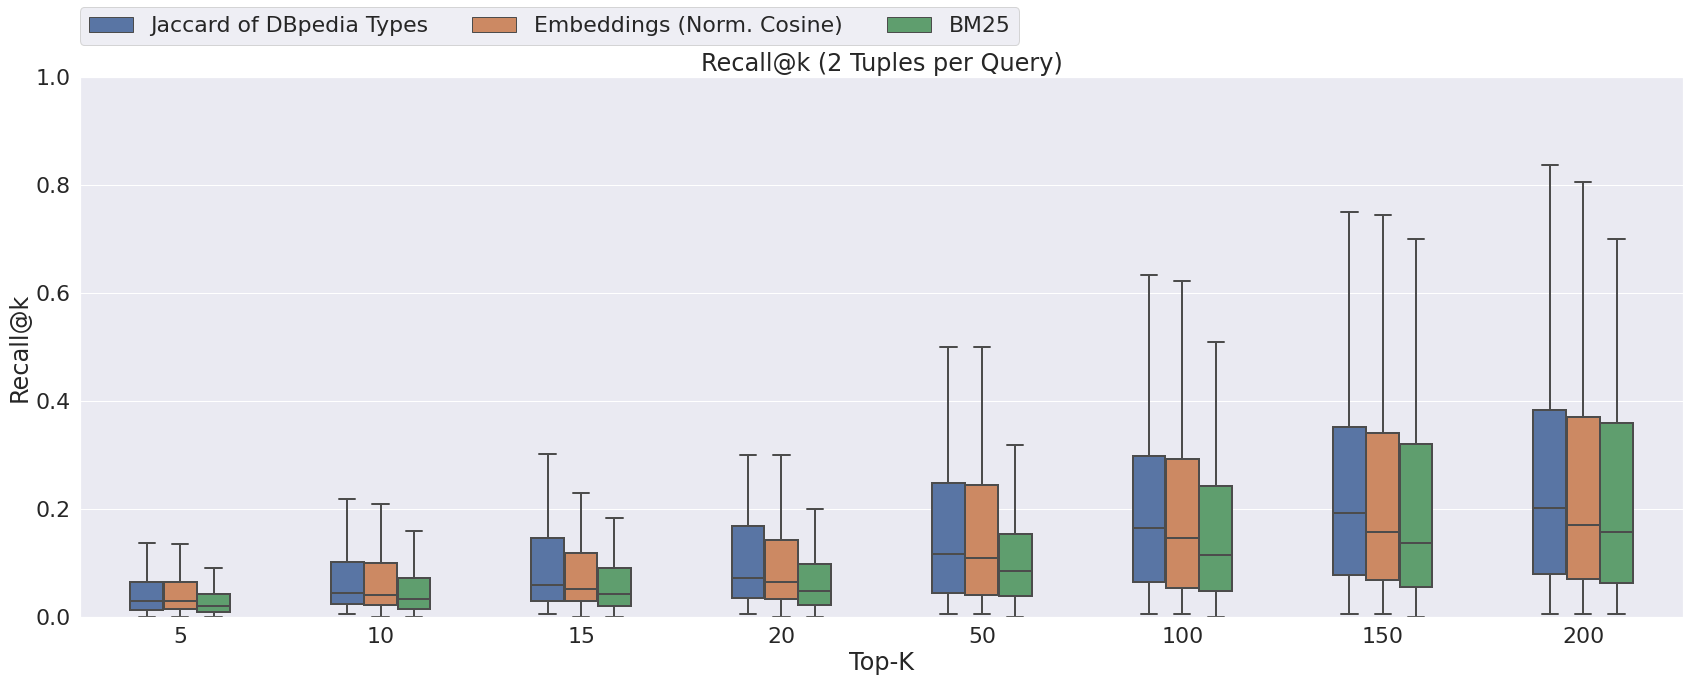

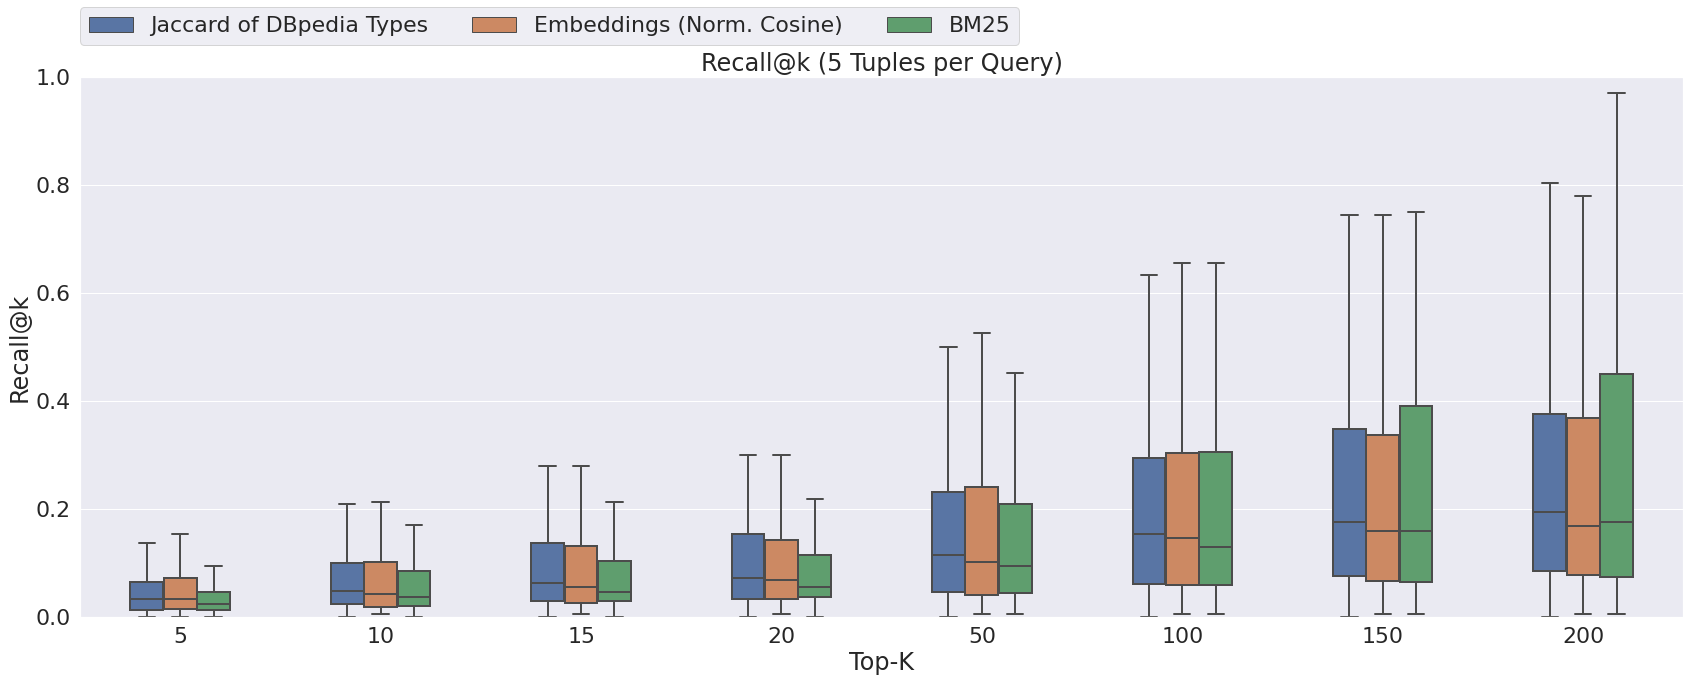

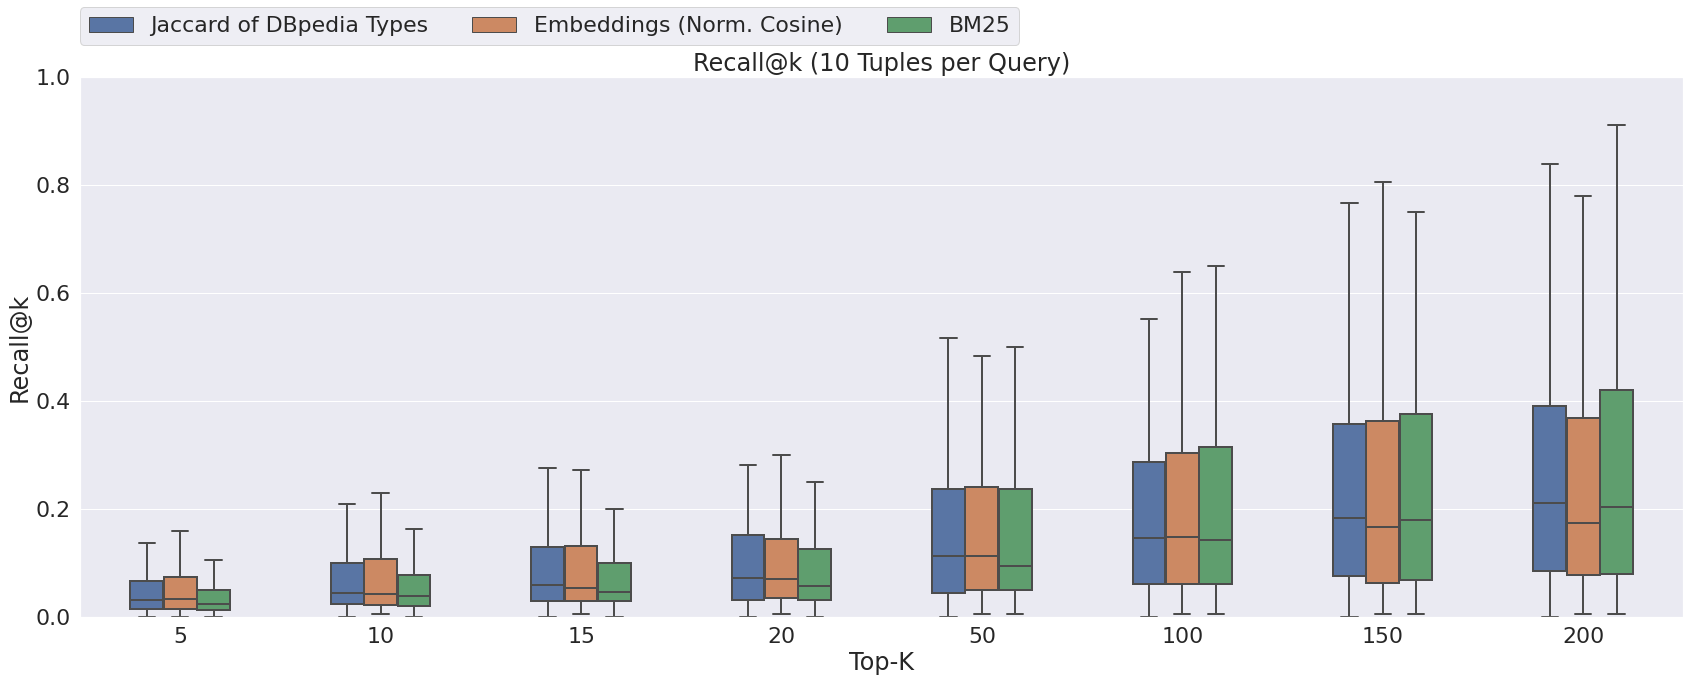

In [53]:
for tuples_per_query in tuples_per_query_list:
    plt.figure()
    df = eval_score_to_eval_df_dict['recall'][eval_score_to_eval_df_dict['recall']['tuples_per_query']==tuples_per_query]
    ax = sns.boxplot(x="top-k", y="recall", hue="mode", data=df, showfliers=False, width=0.5, linewidth=2)
    plt.legend(bbox_to_anchor=(0, 1.13), loc=2, borderaxespad=0.,ncol=3)
    plt.ylim(0,1);plt.xlabel("Top-K");plt.ylabel("Recall@k");plt.title("Recall@k (" + str(tuples_per_query)+ " Tuples per Query)");plt.tight_layout()

# Comparison per stratum

In [126]:
def get_filtered_df(eval_df, stratum, tuple_width, num_relevant_tables, tuples_per_query):
    filtered_df = eval_df[(eval_df['stratum'] == stratum) & (eval_df['tuples_per_query']==tuples_per_query)]
    
    # Filter k
    if num_relevant_tables == "[20,50)":
        filtered_df = filtered_df[filtered_df['top-k']<=20]
    elif num_relevant_tables == "[50,150)":
        filtered_df = filtered_df[filtered_df['top-k']<=50]
    else:
        filtered_df = filtered_df[filtered_df['top-k']<=150]

    return filtered_df

def get_figure(num_relevant_tables_list, tuple_width, tuples_per_query):
    fig, ax = plt.subplots(1,3)

    for i in range(len(num_relevant_tables_list)):
        num_relevant_tables=num_relevant_tables_list[i]
        stratum = 'Tuple Width '+ str(tuple_width) + ' with ' + num_relevant_tables + ' relevant tables'
        filtered_df = get_filtered_df(
            eval_df=eval_df, stratum=stratum, tuple_width=tuple_width,
            num_relevant_tables=num_relevant_tables, tuples_per_query=tuples_per_query
        )

        ax0 = sns.boxplot(x="top-k", y="ndcg_score", hue="mode", data=filtered_df, showfliers=False, width=0.5, linewidth=2, ax=ax[i])
        ax0.set_title(stratum);ax0.set_ylim(0,1)

    # Remove legend
    for axis in ax:
        axis.legend([],[], frameon=False)
    fig.subplots_adjust(wspace=0.15)
    plt.tight_layout()

    return fig

In [127]:
sampled_queries_df = pd.read_pickle('../../data/queries/wikipages/query_dataframes/expanded_wikipages/sampled_queries/sampled_queries.pickle')

# Maps each wikipage_id to each respective stratum
wikipage_id_to_stratum_dict = {}

for idx, row in sampled_queries_df.iterrows():
    wikipage_id = int(row['wikipage_id'])
    tuple_width = int(row['tuple_width'])   
    tuple_width_name = str(tuple_width) if tuple_width<6 else '>=6'

    num_relevant_tables = row['categories_relevant_tables']
    num_relevant_tables_name=""

    if (num_relevant_tables >=20 and num_relevant_tables < 50):
        num_relevant_tables_name="[20,50)"
    elif (num_relevant_tables >=50 and num_relevant_tables < 150):
        num_relevant_tables_name="[50,150)"
    else:
        num_relevant_tables_name=">=150"
    
    stratum_name = "Tuple Width " + tuple_width_name + " with " + num_relevant_tables_name + ' relevant tables'
    wikipage_id_to_stratum_dict[wikipage_id]=stratum_name

In [128]:
eval_df['stratum'] = None
for idx, row in eval_df.iterrows():
    eval_df.at[idx,'stratum'] = wikipage_id_to_stratum_dict[row['wikipage_id']]
eval_df

,mode,top-k,ndcg_score,wikipage_id,tuples_per_query,stratum
0,Jaccard of DBpedia Types,5,0.876251,205,1,"Tuple Width 3 with [50,150) relevant tables"
1,Jaccard of DBpedia Types,10,0.831041,205,1,"Tuple Width 3 with [50,150) relevant tables"
2,Jaccard of DBpedia Types,15,0.748745,205,1,"Tuple Width 3 with [50,150) relevant tables"
3,Jaccard of DBpedia Types,20,0.669918,205,1,"Tuple Width 3 with [50,150) relevant tables"
4,Jaccard of DBpedia Types,50,0.439844,205,1,"Tuple Width 3 with [50,150) relevant tables"
...,...,...,...,...,...,...
5755,BM25,20,0.271578,243407,2,"Tuple Width 3 with [20,50) relevant tables"
5756,BM25,50,0.261315,243407,2,"Tuple Width 3 with [20,50) relevant tables"
5757,BM25,100,0.261315,243407,2,"Tuple Width 3 with [20,50) relevant tables"
5758,BM25,150,0.261315,243407,2,"Tuple Width 3 with [20,50) relevant tables"


## 1 Tuple per Query

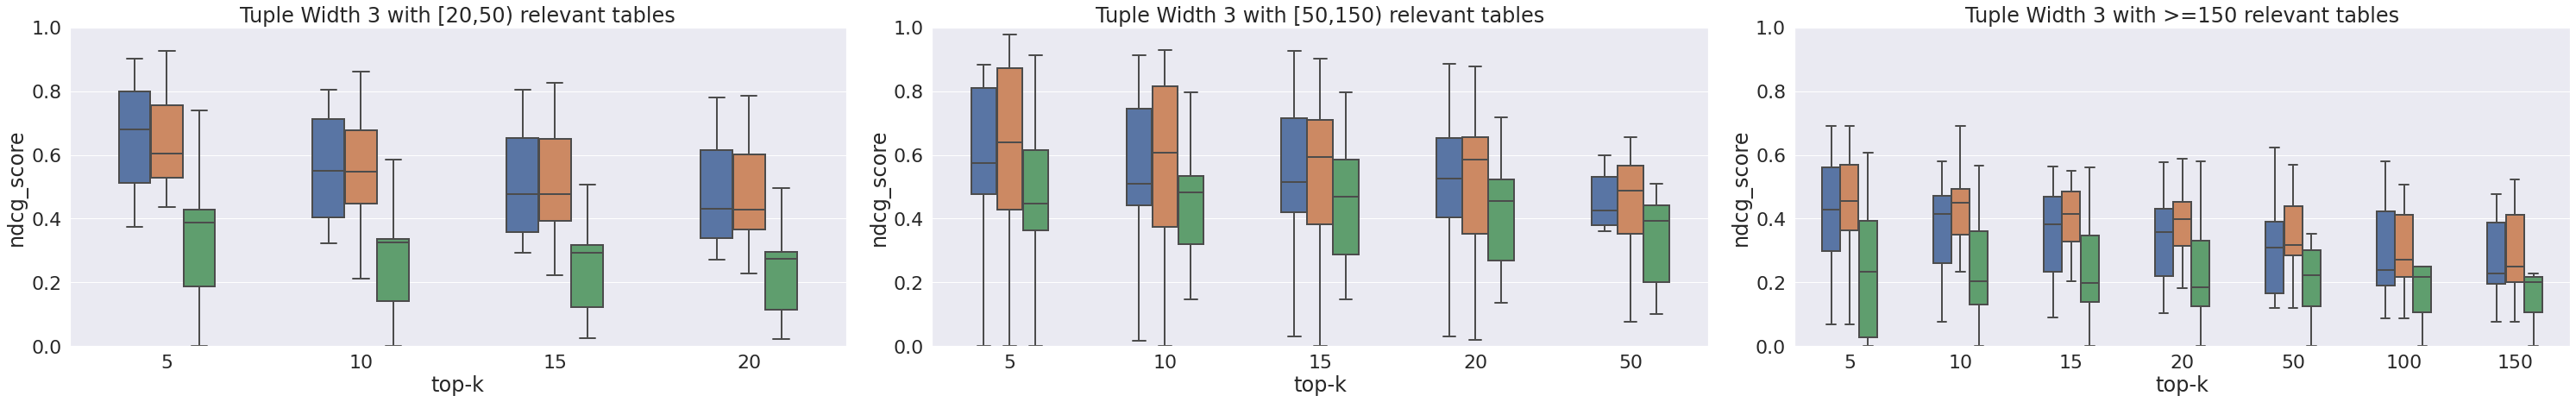

In [129]:
sns.set(rc={'figure.figsize':(42, 7)}, font_scale=2)
num_relevant_tables_list=['[20,50)', '[50,150)', '>=150']

fig = get_figure(num_relevant_tables_list=num_relevant_tables_list, tuple_width=3, tuples_per_query=1)
plt.savefig('figures/wikipages_expanded/sampled_queries/stratum_evaluation_1_tuple_per_query_tuple_width_3.svg')

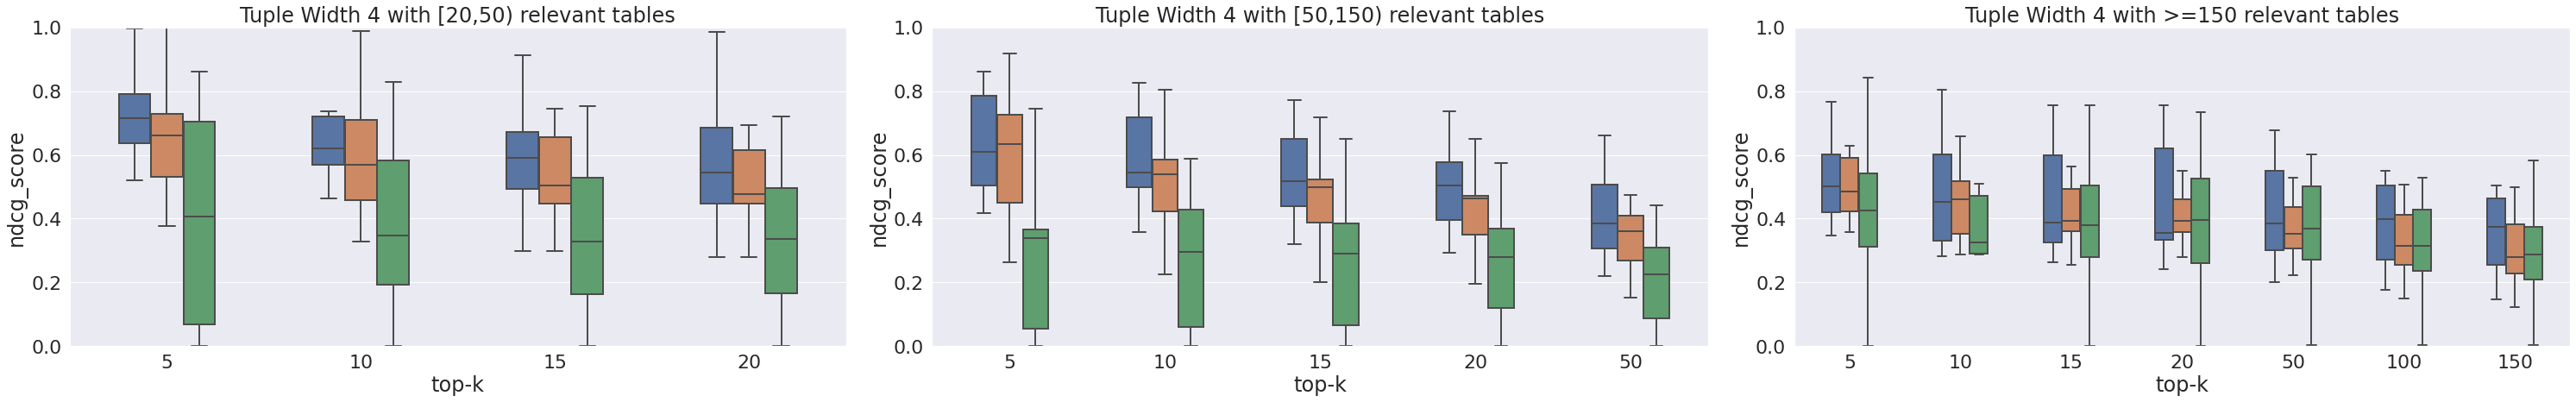

In [130]:
fig = get_figure(num_relevant_tables_list=num_relevant_tables_list, tuple_width=4, tuples_per_query=1)
plt.savefig('figures/wikipages_expanded/sampled_queries/stratum_evaluation_1_tuple_per_query_tuple_width_4.svg')

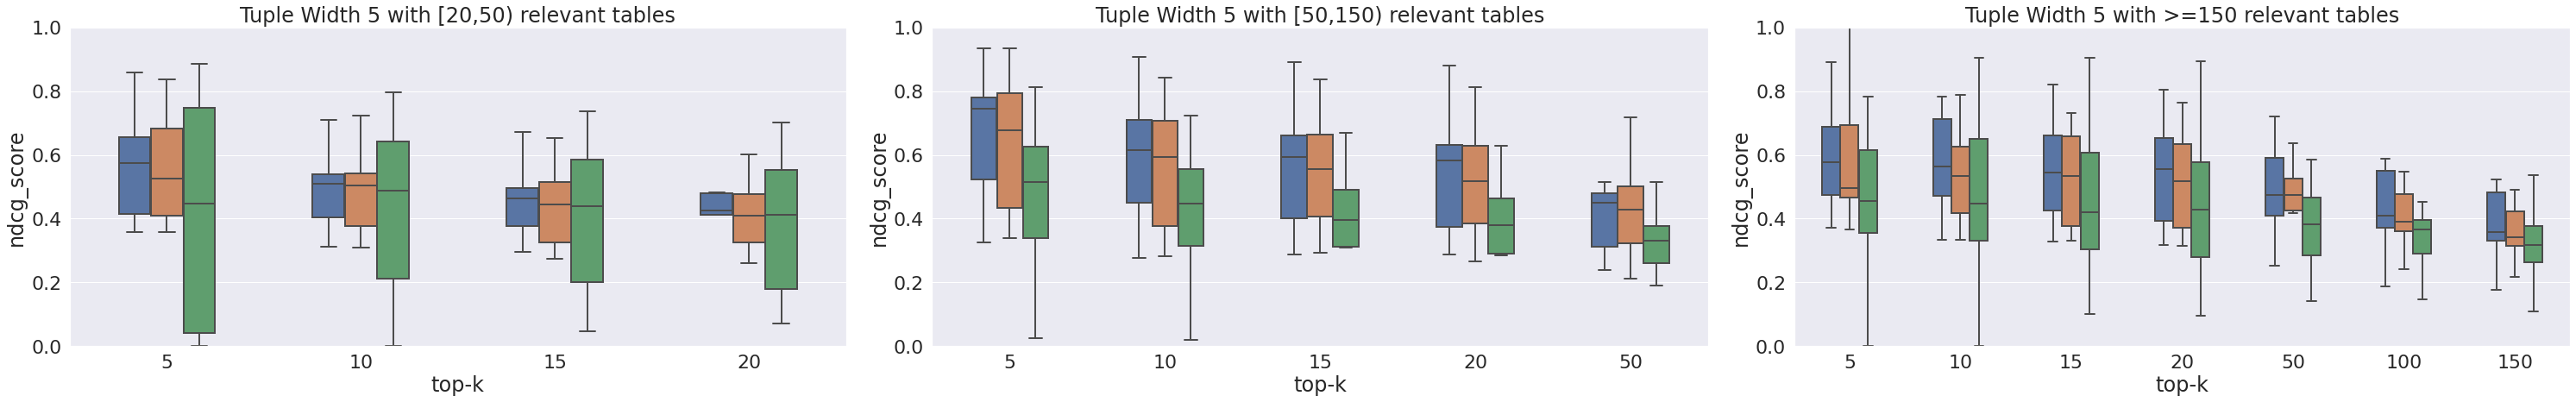

In [131]:
fig = get_figure(num_relevant_tables_list=num_relevant_tables_list, tuple_width=5, tuples_per_query=1)
plt.savefig('figures/wikipages_expanded/sampled_queries/stratum_evaluation_1_tuple_per_query_tuple_width_5.svg')

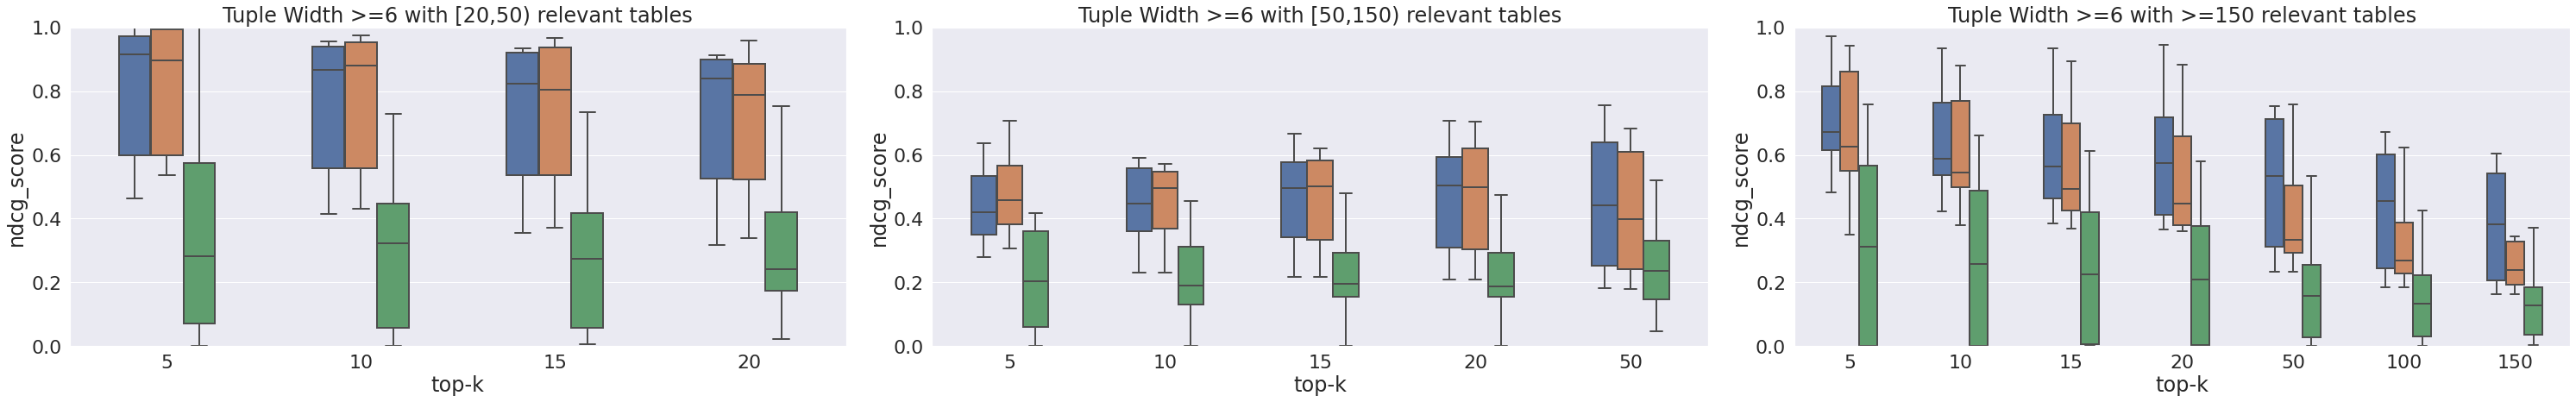

In [132]:
fig = get_figure(num_relevant_tables_list=num_relevant_tables_list, tuple_width=">=6", tuples_per_query=1)
plt.savefig('figures/wikipages_expanded/sampled_queries/stratum_evaluation_1_tuple_per_query_tuple_width_6.svg')

## 2 Tuples per Query

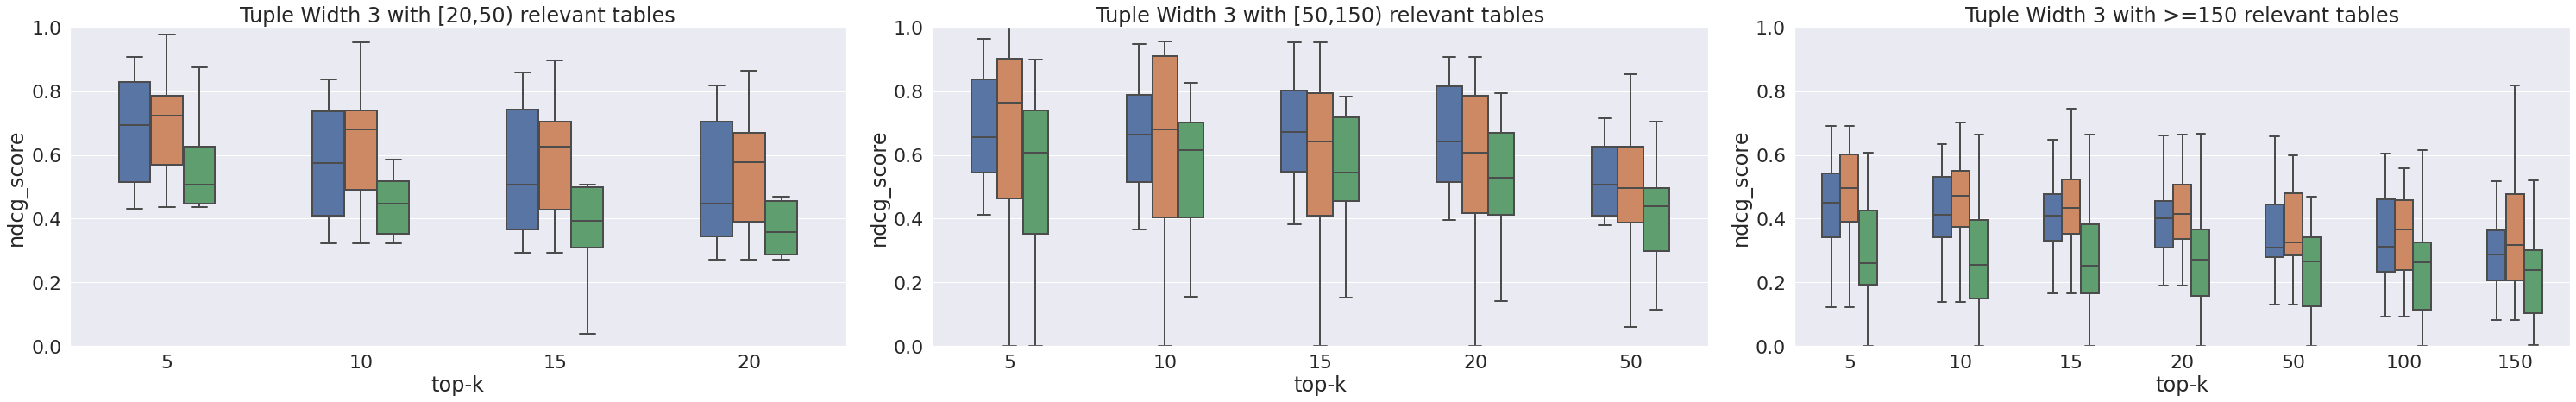

In [133]:
num_relevant_tables_list=['[20,50)', '[50,150)', '>=150']

fig = get_figure(num_relevant_tables_list=num_relevant_tables_list, tuple_width=3, tuples_per_query=2)
plt.savefig('figures/wikipages_expanded/sampled_queries/stratum_evaluation_2_tuples_per_query_tuple_width_3.svg')

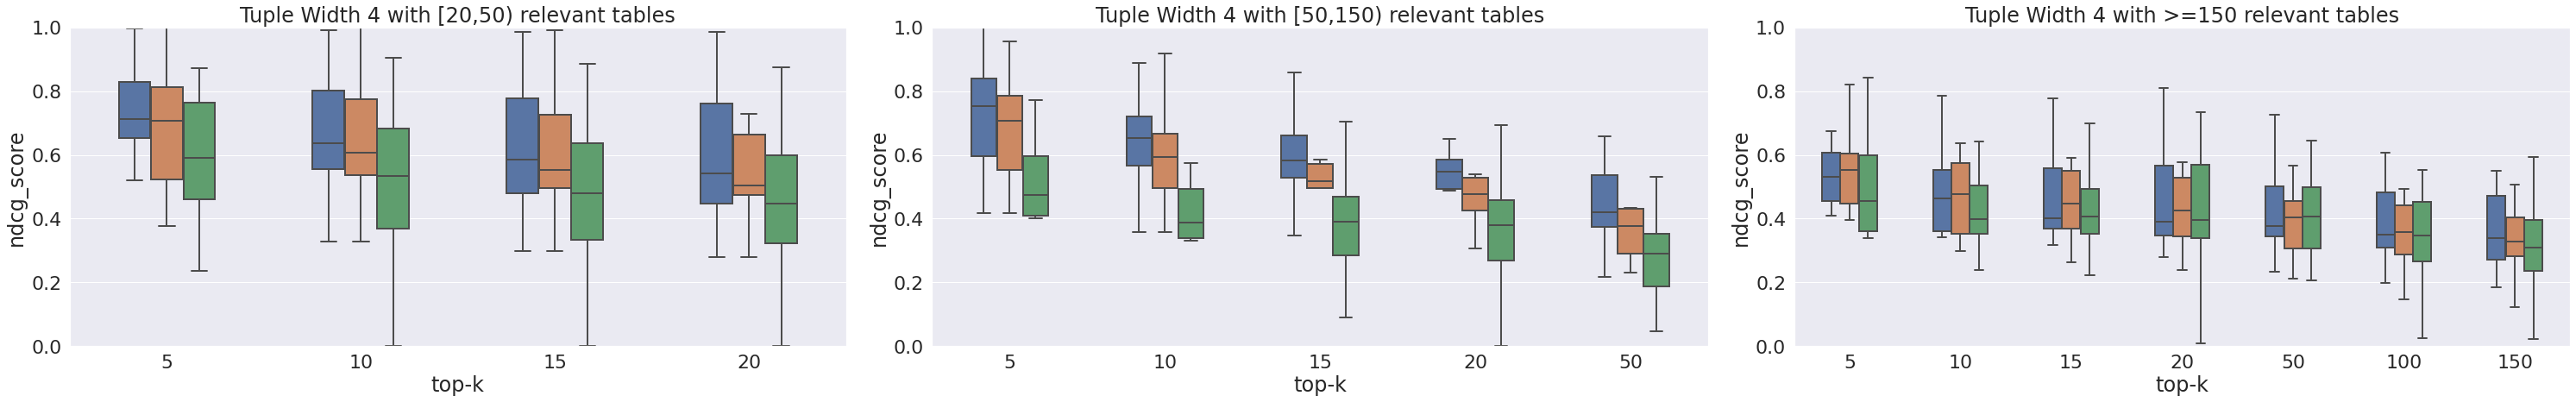

In [134]:
fig = get_figure(num_relevant_tables_list=num_relevant_tables_list, tuple_width=4, tuples_per_query=2)
plt.savefig('figures/wikipages_expanded/sampled_queries/stratum_evaluation_2_tuples_per_query_tuple_width_4.svg')

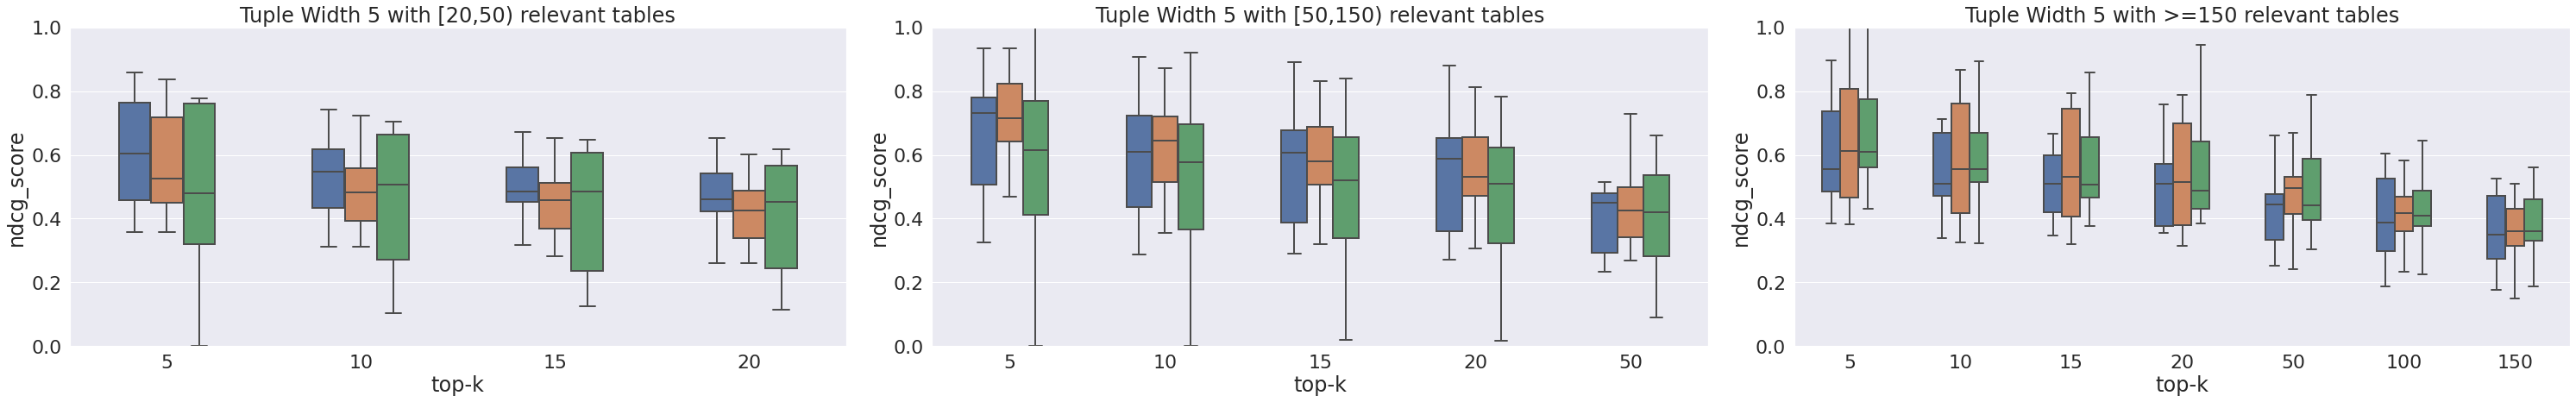

In [135]:
fig = get_figure(num_relevant_tables_list=num_relevant_tables_list, tuple_width=5, tuples_per_query=2)
plt.savefig('figures/wikipages_expanded/sampled_queries/stratum_evaluation_2_tuples_per_query_tuple_width_5.svg')

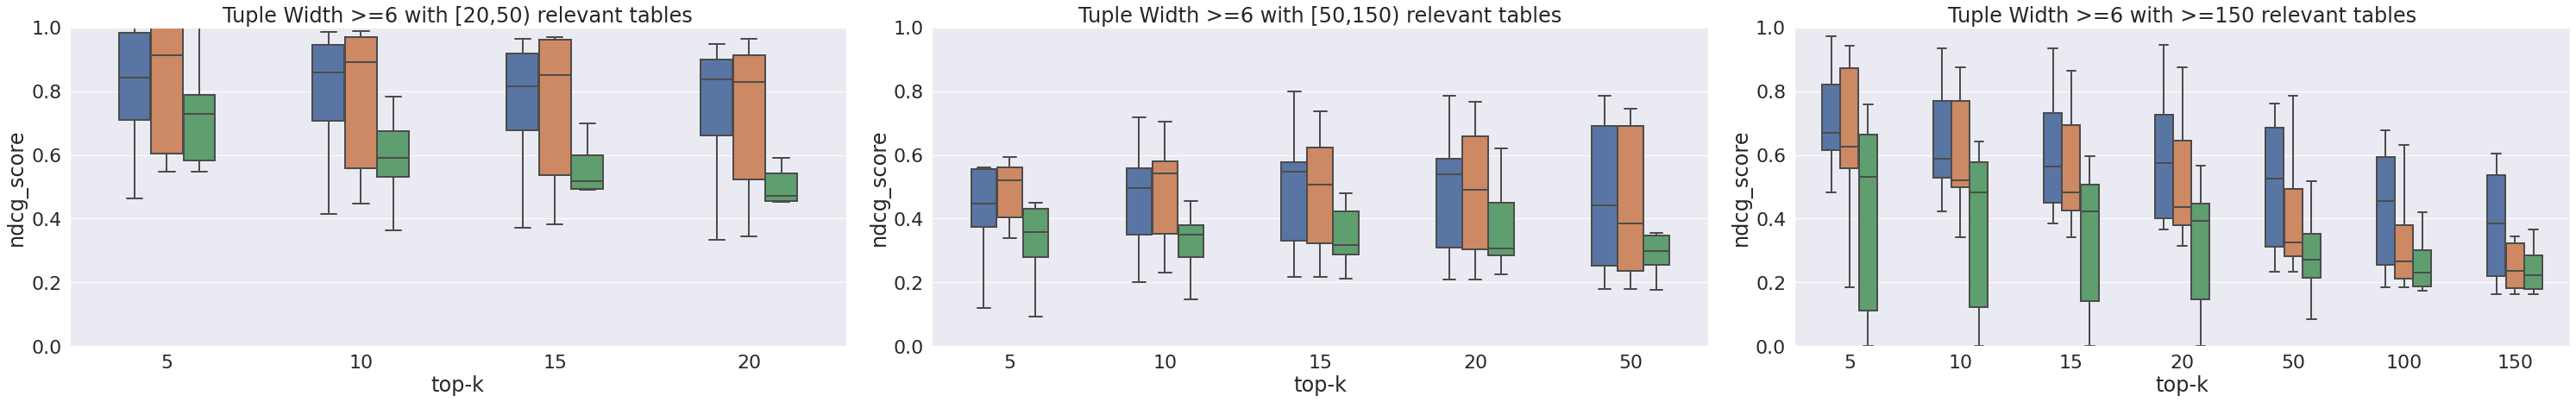

In [136]:
fig = get_figure(num_relevant_tables_list=num_relevant_tables_list, tuple_width=">=6", tuples_per_query=2)
plt.savefig('figures/wikipages_expanded/sampled_queries/stratum_evaluation_2_tuples_per_query_tuple_width_6.svg')

## Evaluation statistics per Stratum

### 1 Tuple per Query

In [137]:
tmp_df = eval_df[eval_df['tuples_per_query']==1]
tmp_df = tmp_df.groupby(by=['mode', 'stratum', 'top-k']).mean()
tmp_df

ndcg_score
mode                     stratum                                       top-k            
BM25                     Tuple Width 3 with >=150 relevant tables      5        0.235080
                                                                       10       0.238205
                                                                       15       0.240351
                                                                       20       0.236886
                                                                       50       0.241243
...                                                                                  ...
Jaccard of DBpedia Types Tuple Width >=6 with [50,150) relevant tables 20       0.465653
                                                                       50       0.456593
                                                                       100      0.417121
                                                                       150      0.386303
                                                                       200      0.386303

[288 rows x 1 columns]

In [138]:
tmp_df.loc['BM25'].loc['Tuple Width 3 with >=150 relevant tables'].loc[20]

ndcg_score    0.236886
Name: 20, dtype: float64

In [139]:
test_df = eval_df[(eval_df['tuples_per_query']==1) & (eval_df['mode']=='BM25') & (eval_df['stratum'] == 'Tuple Width 3 with >=150 relevant tables') & (eval_df['top-k']==20)]
test_df['ndcg_score'].mean()

0.23688562387120773

In [148]:
selected_wikipage_ids = set(eval_df[eval_df['stratum']=='Tuple Width 5 with [20,50) relevant tables']['wikipage_id'].to_list())

sampled_queries_df[sampled_queries_df['wikipage_id'].isin(selected_wikipage_ids)]

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,categories_relevant_wikipages,categories_relevant_tables,navigation_links_relevant_wikipages,navigation_links_relevant_tables,categories_expansion_ratio,navigation_links_expansion_ratio,avg_query_containment
86905,https://en.wikipedia.org/wiki/List_of_races_at...,86905,1,[table-0586-204.json],[160],5.0,10.0,table-0586-204.json,"[0, 1, 2, 3, 13, 14, 15, 16, 17, 18]",5.0,40.0,NaN,NaN,40.000000,NaN,0.036729
97523,https://en.wikipedia.org/wiki/2010_Super_GT_se...,97523,4,"[table-0659-185.json, table-0659-186.json, tab...","[35, 50, 26, 12]",5.0,10.0,table-0659-185.json,"[0, 4, 5, 7, 8, 13, 17, 18, 23, 25]",14.0,49.0,NaN,NaN,12.250000,NaN,0.203333
132362,https://en.wikipedia.org/wiki/England_rugby_un...,132362,1,[table-0901-878.json],[69],5.0,16.0,table-0901-878.json,"[26, 30, 34, 37, 40, 42, 49, 52, 53, 54, 57, 6...",22.0,27.0,NaN,NaN,27.000000,NaN,0.123342
160764,https://en.wikipedia.org/wiki/2012_Super_GT_se...,160764,7,"[table-1097-949.json, table-1097-950.json, tab...","[25, 17, 41, 63, 28, 14, 10]",5.0,10.0,table-1097-951.json,"[3, 4, 6, 15, 16, 19, 20, 23, 28, 29]",12.0,40.0,NaN,NaN,5.714286,NaN,0.292899
185669,https://en.wikipedia.org/wiki/Western_Sydney_D...,185669,1,[table-1271-207.json],[16],5.0,10.0,table-1271-207.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",28.0,45.0,NaN,NaN,45.000000,NaN,0.038352
199178,https://en.wikipedia.org/wiki/Romanian_Footbal...,199178,2,"[table-1361-284.json, table-1361-285.json]","[56, 17]",5.0,11.0,table-1361-284.json,"[11, 12, 13, 14, 16, 20, 21, 39, 40, 41, 45]",14.0,22.0,NaN,NaN,11.000000,NaN,0.020408
204543,https://en.wikipedia.org/wiki/MLS_Cup,204543,4,"[table-1393-710.json, table-1393-711.json, tab...","[51, 21, 11, 35]",5.0,11.0,table-1393-710.json,"[4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16]",14.0,28.0,NaN,NaN,7.000000,NaN,0.296296
218050,https://en.wikipedia.org/wiki/List_of_sniper_r...,218050,1,[table-1479-973.json],[185],5.0,19.0,table-1479-973.json,"[5, 6, 7, 8, 16, 18, 19, 20, 22, 23, 24, 31, 3...",11.0,20.0,NaN,NaN,20.000000,NaN,0.106337
227076,https://en.wikipedia.org/wiki/List_of_World_Se...,227076,2,"[table-1543-349.json, table-1543-350.json]","[411, 29]",5.0,86.0,table-1543-349.json,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",19.0,49.0,NaN,NaN,24.500000,NaN,0.018787
242282,https://en.wikipedia.org/wiki/Super_Prestige_P...,242282,1,[table-1641-979.json],[49],5.0,17.0,table-1641-979.json,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 17, 18, 19...",23.0,46.0,NaN,NaN,46.000000,NaN,0.001905


In [162]:
eval_df[(eval_df['wikipage_id'].isin(selected_wikipage_ids)) & (eval_df['wikipage_id']==242282) & (eval_df['top-k']<=20)]

,mode,top-k,ndcg_score,wikipage_id,tuples_per_query,stratum
936,Jaccard of DBpedia Types,5,0.858315,242282,1,"Tuple Width 5 with [20,50) relevant tables"
937,Jaccard of DBpedia Types,10,0.743206,242282,1,"Tuple Width 5 with [20,50) relevant tables"
938,Jaccard of DBpedia Types,15,0.671145,242282,1,"Tuple Width 5 with [20,50) relevant tables"
939,Jaccard of DBpedia Types,20,0.617576,242282,1,"Tuple Width 5 with [20,50) relevant tables"
1896,Jaccard of DBpedia Types,5,0.858315,242282,2,"Tuple Width 5 with [20,50) relevant tables"
1897,Jaccard of DBpedia Types,10,0.743206,242282,2,"Tuple Width 5 with [20,50) relevant tables"
1898,Jaccard of DBpedia Types,15,0.671145,242282,2,"Tuple Width 5 with [20,50) relevant tables"
1899,Jaccard of DBpedia Types,20,0.617576,242282,2,"Tuple Width 5 with [20,50) relevant tables"
2856,Embeddings (Norm. Cosine),5,0.836412,242282,1,"Tuple Width 5 with [20,50) relevant tables"
2857,Embeddings (Norm. Cosine),10,0.724241,242282,1,"Tuple Width 5 with [20,50) relevant tables"


In [165]:
sampled_queries_df[sampled_queries_df['wikipage_id']==199178]['wikipage'].values

array(['https://en.wikipedia.org/wiki/Romanian_Footballer_of_the_Year'],
      dtype=object)